# Market Microstructure of the Intraday Limit Order Book.

In this notebook we are going to understand some market microstructure at the order book level. The given data, represents market orders (layer one of the order book).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Analytics.TimeSeriesTools import * 
import scipy.stats as ss
import seaborn as sns



plt.style.use('seaborn')


%load_ext autoreload
%autoreload 2

In [2]:
# Loading Data

df_wap_bal = pd.read_csv('strategy_data_lobniv.csv', index_col = 0, parse_dates=True)
raw_quotes = pd.read_pickle('outfile')
quotes = pd.DataFrame(raw_quotes)
quotes.columns = ['delivery_time', 'order_book']
quotes.set_index('delivery_time', drop=True, inplace=True)
quotes.loc['2022-07-28 00:00:00+00:00'].order_book.drop(columns = 'delivery_time', inplace=True)
df_wap_bal = df_wap_bal[['wap1', 'niv', 'imb']]
quotes['niv'] = df_wap_bal.niv
quotes['imb'] = df_wap_bal.imb

# Fundamentals of market microstructure.


When analysing the limit order book (LOB) it is important to look at some specific features:

- The bid-ask spread
- The mid-price
- The microprice
- The LOB imbalance


In the following we are going to use the following notation:

- $Q^a, Q^b$ represent the quantity of the best ask and best bid respectively in the LOB;
- $P^a, P^b$ represent the best ask and the best bid price respectively in the LOB;

We recall that the best bid and ask are always at the very first layer of the order book, and the dataset we will be using corresponds to the change in time of the LOB at layer one for every settlement period contract.


**definition**. The bid-ask spread is a positive real number defined by:

$$ S_{ab} = P^a - P^b $$

The quantity $S_{ab}$ measures the *liquidity* in the market. The bigger the spread the less liquid is the market. In practice a not so liquid market happens when there is not so much trading activity happening, that is there is very little to no trade execution in the market.

**definition**. The mid price is a real number defined by:

$$ m_{ab} = \frac{1}{2} ( P^a + P^b ) $$

The quantity $m_{ab}$ is often taken has the most probable traded price to happen. From a *supply & demand* dynamical point of view it means that the supply (the bid side) meets the demand (the ask side) in the middle.
Nevertheless, this quantity does not take into account if the liquidity providers are somewhat informed on where the market is headed. The quantity of information in the LOB is represented by the size of the bid and the ask. This motivates the following:

**definition**. The microprice is a real number defined by:

$$ \mu_{ab} = P^a I + P^b (1-I), $$ 

where the quantity $I$ is called *imbalance* and is defined as follows:

$$ I = \frac{Q^b}{Q^a + Q^b}. $$

The microprice is what is believed to be a informed pattern in the market which should be closed to actual trades. It is the *most balanced* price in the orderbook. At last we will be defining the order book imbalance, the latter quantity is also a real number and measures where the quantity of information (size) is pressuring the order book.

**definition** The order book imbalance is a real number defined as

$$ \rho = \frac{Q^b - Q^a}{Q^a + Q^b} $$

If $\rho > 0$ then there is a strong selling pressure, viceversa if the latter is negative then there is a strong buy pressure.

In [19]:
def bid_ask_spread(bid: np.array, ask: np.array) -> np.array:
    return ask-bid

def midprice(bid: np.array, ask: np.array) -> np.array:
    return 0.5 * (ask + bid)

def microprice(bid_size: np.array, bid:np.array, ask:np.array, ask_size:np.array) -> np.array:
    I = bid_size / (bid_size + ask_size)
    return ask * I + bid * (1-I)

def lob_imbalance(bid_size:np.array, ask_size:np.array) -> np.array:
    num = bid_size - ask_size
    den = bid_size + ask_size
    return num/den

In [98]:
# Create a market microstructure dataframe.

deliveries = quotes.index

micro_data = []

for delivery_time in deliveries:
    
    order_book = quotes.loc[str(delivery_time)].order_book.dropna()
    
    mkt_micro = pd.concat([abs(bid_ask_spread(bid = order_book.bid, ask = order_book.ask)), 
                           midprice(order_book.bid, order_book.ask),
                           microprice(bid_size = order_book.bid_size, 
                                      bid = order_book.bid, 
                                      ask = order_book.ask, 
                                      ask_size = order_book.ask_size),
                           lob_imbalance(bid_size = order_book.bid_size, 
                                         ask_size = order_book.ask_size)], axis=1)
    mkt_micro.columns = ['spread', 'midprice', 'microprice', 'imb_lob']
    mkt_micro['delivery_time'] = len(mkt_micro)*[delivery_time]
    
    micro_data.append(mkt_micro)
        
micro_df = pd.concat([micro_data[k] for k in range(len(micro_data))], axis=0)

# Adding fundamental data

mkt_df = micro_df.copy()

mkt_df['timestamp'] = mkt_df.index
mkt_df.set_index('delivery_time', inplace=True)
mkt_df['niv'] = quotes.niv
mkt_df['imb_pri'] = quotes.imb

# adding a new feature
mkt_df['time_to_delivery'] = (pd.to_datetime(mkt_df.index, utc=True) - pd.to_datetime(mkt_df.timestamp.values, utc=True)).total_seconds()/60

# Reordering columns

mkt_df = mkt_df[['timestamp', 'spread', 'midprice', 'microprice', 'imb_lob', 'time_to_delivery', 'niv', 'imb_pri']]
        

# Some stylized facts on a intraday power market order flows.

- Liquidity increases when close to delivery time.
- Prices increases if the niv direction is positive.
- Prices decreases if the niv direction is negative.
- The order book imbalance follows the niv direction.

We are going to see all these stylized facts with some plots. We recall that a intraday half hour contract, closes 15 minutes before delivery. 

## Liquidity increases when an instrument is close to delivery

As mentioned before, a measure of liquidity is given by the bid ask spread. So we would expect that when far away from delivery time this spread is big and when the instrument is in delivery the spread is small.

To see this, at every delivery time we will set as index the time to delivery and retrieve the index at which the spread encounters its minimum and its maximum.

<AxesSubplot:xlabel='timestamp'>

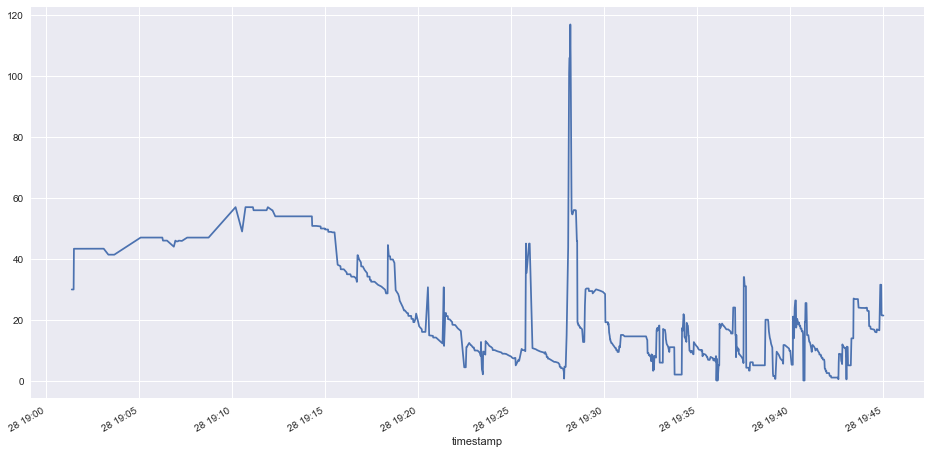

In [102]:
rnd_delivery_time = np.random.choice(deliveries)

mkt_df.loc[rnd_delivery_time].set_index('timestamp').spread.plot(figsize = (16,8))

In [140]:
mkt_df

,timestamp,spread,midprice,microprice,imb_lob,time_to_delivery,niv,imb_pri
delivery_time,,,,,,,,
2022-07-28 00:00:00+00:00,2022-07-27 23:13:25,43.30,246.650,261.638462,0.692308,46.583333,-120.34,201.00
2022-07-28 00:00:00+00:00,2022-07-27 23:13:26,43.28,246.660,260.964407,0.661017,46.566667,-120.34,201.00
2022-07-28 00:00:00+00:00,2022-07-27 23:13:40,24.87,237.455,245.674746,0.661017,46.333333,-120.34,201.00
2022-07-28 00:00:00+00:00,2022-07-27 23:13:49,19.87,234.955,241.522203,0.661017,46.183333,-120.34,201.00
2022-07-28 00:00:00+00:00,2022-07-27 23:13:58,19.87,234.955,241.522203,0.661017,46.033333,-120.34,201.00
...,...,...,...,...,...,...,...,...
2022-10-01 23:30:00+00:00,2022-10-01 23:14:44,14.89,92.455,92.455000,0.000000,15.266667,-72.39,62.86
2022-10-01 23:30:00+00:00,2022-10-01 23:14:46,20.99,104.405,108.868391,0.425287,15.233333,-72.39,62.86
2022-10-01 23:30:00+00:00,2022-10-01 23:14:50,29.30,100.150,93.871429,-0.428571,15.166667,-72.39,62.86


In [103]:
liquidity = {'delivery_time': [] , 'when_spread_max': [], 'spread_max': [], 'when_spread_min': [], 'spread_min': []}

for delivery_time in mkt_df.index.unique():
    
    df = mkt_df.loc[delivery_time].set_index('time_to_delivery')

    when_max = df.spread.idxmax()
    max_ = df.spread.max()
    when_min = df.spread.idxmin()
    min_ = df.spread.min()

    liquidity['delivery_time'].append(delivery_time)
    liquidity['when_spread_max'].append(when_max)
    liquidity['spread_max'].append(max_)
    liquidity['when_spread_min'].append(when_min)
    liquidity['spread_min'].append(min_)

    
liquidity = pd.DataFrame(liquidity)
liquidity.set_index('delivery_time', inplace=True)

In [107]:
liquidity.describe().round(2)

,when_spread_max,spread_max,when_spread_min,spread_min
count,3108.00,3108.00,3108.00,3108.00
mean,45.26,90.94,32.31,0.12
std,13.99,173.01,12.67,0.47
min,14.68,5.80,15.00,0.00
25%,35.82,49.99,21.23,0.00
50%,50.92,70.92,29.29,0.01
75%,56.53,102.65,41.82,0.09
max,59.98,5364.07,59.93,19.10


The above table confirms the stylized fact. Moreover, as a general fact when the liquidity is scarce (hence the bid-ask spread is big), then the trading activity is quite low. Instead, when there is a lot of liquidity (hence the bid-ask spread is small), then the trading activity is quite high. From a trading perspective, the probability to get into a trade when the liquidity is high is very high as well, whereas when liquidity is very low, the probability of getting hit in the market becomes much lower (unless somebody sends market orders).

## Price movements compared to fundamental data.

In this section we are going to see that when the NIV has positive sign the the microprice will increase from beginning to the end, and when the NIV has positive sign, the microprice will decrease from the beginning to the end. 

In [133]:
price_movement = {'delivery_time': [], 'start_price': [], 'end_price': [], 'change': [], 'niv': []}


for delivery_time in mkt_df.index.unique():
    
    df = mkt_df.loc[delivery_time]
    
    start = df.microprice[0]
    end = df.microprice[-1]
    change = end - start
              
    price_movement['delivery_time'].append(delivery_time)
    price_movement['start_price'].append(start)
    price_movement['end_price'].append(end)
    price_movement['change'].append(change)
    price_movement['niv'].append(float(df.niv.unique()))
    
    
price_movement=pd.DataFrame(price_movement).round(2)
price_movement.set_index('delivery_time', drop=True, inplace=True)


In [134]:
price_movement

,start_price,end_price,change,niv
delivery_time,,,,
2022-07-28 00:00:00+00:00,261.64,223.95,-37.69,-120.34
2022-07-28 00:30:00+00:00,221.00,206.59,-14.41,-156.28
2022-07-28 01:00:00+00:00,236.46,218.87,-17.59,-78.31
2022-07-28 01:30:00+00:00,226.63,230.28,3.65,-97.40
2022-07-28 02:00:00+00:00,240.60,226.16,-14.45,-160.25
...,...,...,...,...
2022-10-01 21:30:00+00:00,181.16,110.39,-70.76,-109.39
2022-10-01 22:00:00+00:00,206.15,134.54,-71.61,183.17
2022-10-01 22:30:00+00:00,169.99,211.78,41.79,52.72


In [137]:
is_negative = price_movement.query('change<0 & niv<0').shape[0]
is_positive = price_movement.query('change>0 & niv>0').shape[0]

neg_nc = price_movement.query('change>0 & niv<0').shape[0]
pos_nc = price_movement.query('change<0 & niv>0').shape[0]

freq_neg = is_negative / price_movement.shape[0]
freq_pos = is_positive / price_movement.shape[0]

freq_neg_nc = neg_nc / price_movement.shape[0]
freq_pos_nc = pos_nc / price_movement.shape[0]

print('Frequency of negative price change compared to negative NIV {:.2f}'.format(freq_neg))
print('Frequency of uncorrectly classified latter case {:.2f}'.format(freq_neg_nc))
print('Frequency of positive price change compared to positive NIV {:.2f}'.format(freq_pos))
print('Frequency of uncorrectly classified latter case {:.2f}'.format(freq_pos_nc))


Frequency of negative price change compared to negative NIV 0.35
Frequency of uncorrectly classified latter case 0.13
Frequency of positive price change compared to positive NIV 0.35
Frequency of uncorrectly classified latter case 0.16


From a strategy point of view if we were willing to assume the knowledge at any point in time of the NIV and buying and selling the spread between the initial microprice and the final microprice at each settlement period, then we are able to reconstruct the total return graph of the first notebook.

<AxesSubplot:xlabel='delivery_time'>

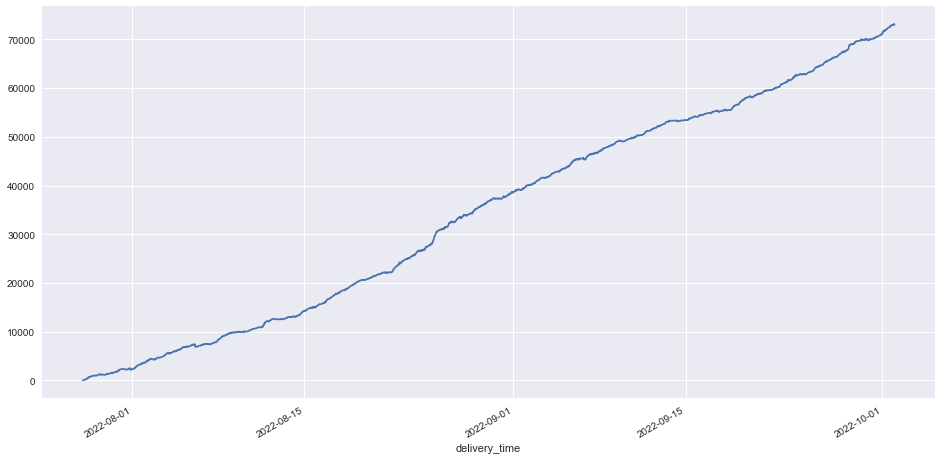

In [139]:
pnl = price_movement.copy()

pnl['positions'] = np.sign(pnl.niv)
pnl['sreturns'] = pnl.positions * pnl.change

pnl.sreturns.cumsum().plot(figsize=(16,8))

## LOB imbalance to NIV direction

The last stylized fact we are going to track is how market participants are informed about the NIV. So we are going to follow on average at every settlement period the limit order book imbalance $\rho$. Recall that, since the dataset consist of a "time series" of market orders we will see that when $\rho>0$ then there is a buying pressure, conversely when $\rho<0$ then there is a selling pressure. When $\rho = 0$ the limit order book is said to be balanced. 

In [143]:
orderbook_imbalance = {'delivery_time': [],
                       'rho_start': [], 
                       'rho_end': [], 
                       'rho_mean': [],
                       'niv' : []}

for delivery_time in mkt_df.index.unique():
    
    df = mkt_df.loc[delivery_time]
    
    rho_start = df.imb_lob[0]
    rho_end = df.imb_lob[-1]
    rho_mean = df.imb_lob.mean()
    niv = df.niv.unique()
    
    orderbook_imbalance['delivery_time'].append(delivery_time)
    orderbook_imbalance['rho_start'].append(rho_start)
    orderbook_imbalance['rho_end'].append(rho_end)
    orderbook_imbalance['rho_mean'].append(rho_mean)
    orderbook_imbalance['niv'].append(float(niv))
    
orderbook_imbalance = pd.DataFrame(orderbook_imbalance).round(2)
orderbook_imbalance.set_index('delivery_time', drop=True, inplace=True)

In [144]:
orderbook_imbalance

,rho_start,rho_end,rho_mean,niv
delivery_time,,,,
2022-07-28 00:00:00+00:00,0.69,-0.02,0.34,-120.34
2022-07-28 00:30:00+00:00,-0.79,0.15,-0.25,-156.28
2022-07-28 01:00:00+00:00,0.75,0.76,-0.69,-78.31
2022-07-28 01:30:00+00:00,0.31,-0.03,-0.58,-97.40
2022-07-28 02:00:00+00:00,0.09,-0.54,-0.62,-160.25
...,...,...,...,...
2022-10-01 21:30:00+00:00,0.34,-0.43,-0.31,-109.39
2022-10-01 22:00:00+00:00,-0.46,0.64,-0.38,183.17
2022-10-01 22:30:00+00:00,-0.67,-0.11,-0.38,52.72


<AxesSubplot:title={'center':'Comparison of Imbalance and NIV'}, xlabel='delivery_time'>

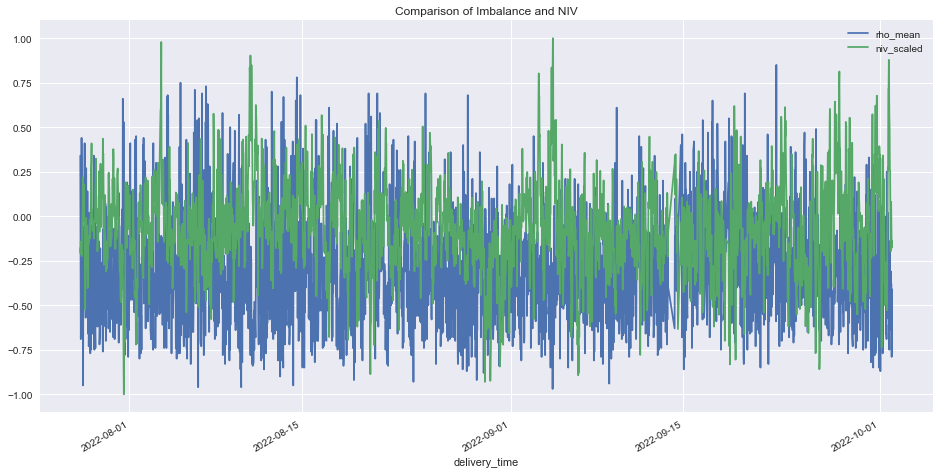

In [152]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
niv_scaled = scaler.fit_transform(orderbook_imbalance.niv.values.reshape(-1,1))



df_imb = pd.DataFrame()

df_imb['rho_mean'] = orderbook_imbalance.rho_mean
df_imb['niv_scaled'] = niv_scaled

df_imb.plot(figsize=(16,8), title='Comparison of Imbalance and NIV')

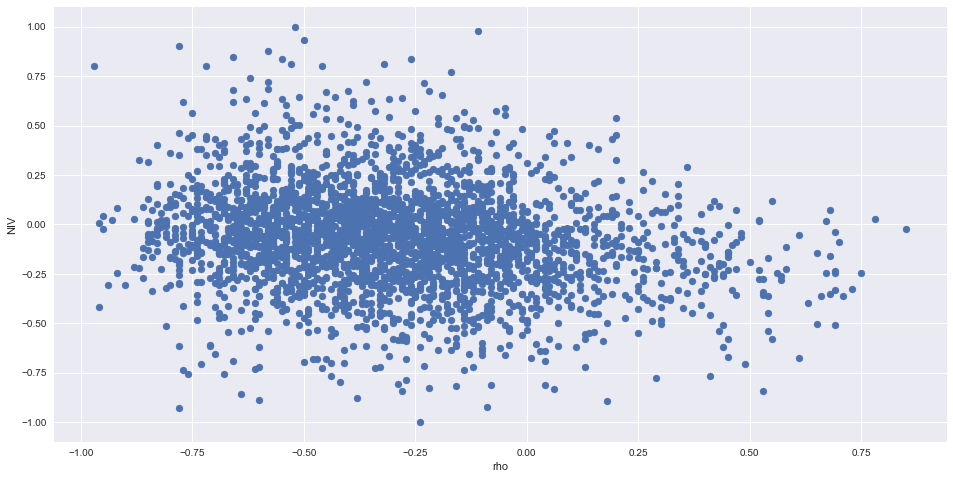

In [156]:
plt.figure(figsize=(16,8))

plt.scatter(x = df_imb.rho_mean, y = df_imb.niv_scaled)
plt.xlabel('rho')
plt.ylabel('NIV')
plt.show()

The uncertainty of information is at the start. Assuming that information is what balances the orderbook, then there is a lot more uncertainty in the beginning than in the end of the settlement period among market participants.

In [167]:
round(orderbook_imbalance.query('rho_start < 0 & niv < 0').shape[0] / orderbook_imbalance.shape[0],2)

0.27

In [168]:
round(orderbook_imbalance.query('rho_start > 0 & niv > 0').shape[0] / orderbook_imbalance.shape[0],2)

0.22

# VWAP price and microprice

In this last section about market microstructure we shall see that the microprice is one of the best predictor of vwap, hence of trades. We shall stress the fact that the microprice does not exist in the market, it is a representation of what it could be the most probable price given the best bid and the best ask spread. It is where the *most balanced demand* meets the *most balanced supply*. Furthermore, the microprice is the closest price to the market.

<AxesSubplot:title={'center':'Avg Microprice per SP'}, xlabel='delivery_time'>

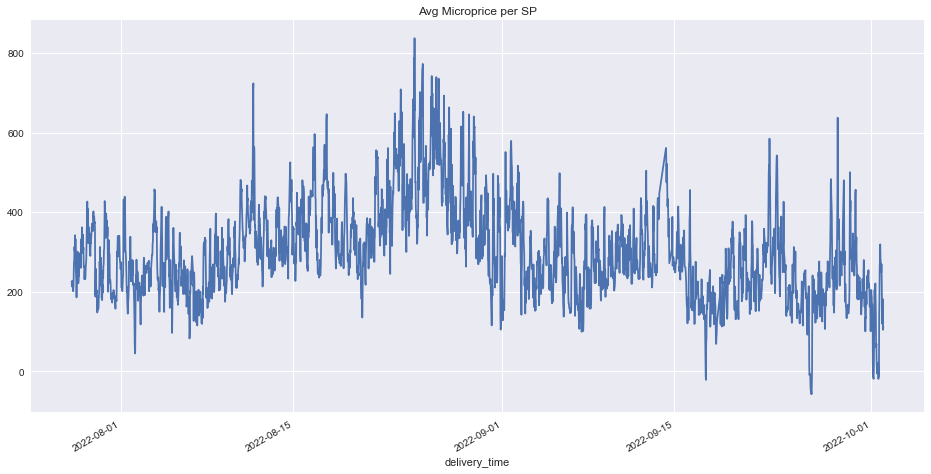

In [174]:
mkt_df.groupby(mkt_df.index).microprice.mean().plot(figsize=(16,8), title = 'Avg Microprice per SP')

<AxesSubplot:title={'center':'VWAP'}>

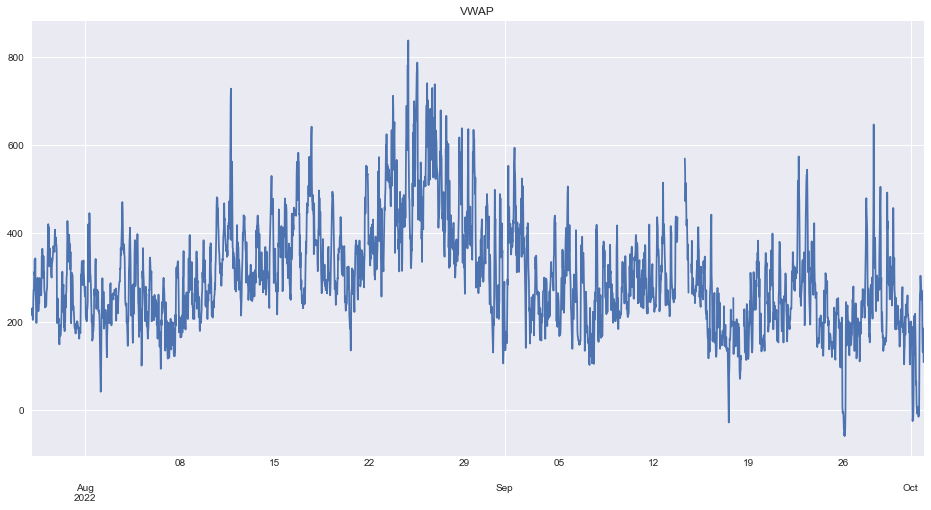

In [175]:
df_wap_bal.wap1[orderbook_imbalance.index[0]:orderbook_imbalance.index[-1]].plot(figsize=(16,8), title = 'VWAP')

In [176]:
vwap_prices = df_wap_bal.wap1[orderbook_imbalance.index[0]:orderbook_imbalance.index[-1]]
avg_micro = mkt_df.groupby(mkt_df.index).microprice.mean()

print_performance_metrics(vwap_prices, avg_micro)

PERFORMANCE METRICS
Mean Absolute Error: 5.26
--------------------------------------------------------------------------------
Mean Squared Error: 56.28
--------------------------------------------------------------------------------
Root Mean Squared Error: 7.50
